In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class FCLayer:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(input_size, output_size) / np.sqrt(input_size + output_size)
        self.bias = np.random.randn(1, output_size) / np.sqrt(input_size + output_size)

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # bias_error = output_error

        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [3]:
class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(input)

    def backward(self, output_error, learning_rate):
        return output_error * self.activation_prime(self.input)

In [4]:
# bonus
class FlattenLayer:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def forward(self, input):
        return np.reshape(input, (1, -1))

    def backward(self, output_error, learning_rate):
        return np.reshape(output_error, self.input_shape)

In [5]:
# bonus
class SoftmaxLayer:
    def __init__(self, input_size):
        self.input_size = input_size

    def forward(self, input):
        self.input = input
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output

    def backward(self, output_error, learning_rate):
        input_error = np.zeros(output_error.shape)
        out = np.tile(self.output.T, self.input_size)
        return self.output * np.dot(output_error, np.identity(self.input_size) - out)

# Activation Function

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_prime(x):
    return np.exp(-x) / (1 + np.exp(-x))**2
def tanh(x):
    return np.tanh(x)
def tanh_prime(x):
    return 1 - np.tanh(x)**2
def relu(x):
    return np.maximum(x, 0)
def relu_prime(x):
    return np.array(x >= 0).astype('int')

# Error Function


In [7]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))
def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_pred.size

def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.power(y_true - y_pred, 2)))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2_score(y_true, y_pred):
    mean_y_true = np.mean(y_true)
    total_sum_of_squares = np.sum(np.power(y_true - mean_y_true, 2))
    residual_sum_of_squares = np.sum(np.power(y_true - y_pred, 2))
    r2 = 1 - (residual_sum_of_squares / total_sum_of_squares)
    return r2

In [8]:
from keras.datasets import mnist
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_train /= 255
y_train = to_categorical(y_train)
x_train = x_train[0:1000]
y_train = y_train[0:1000]

x_test = x_test.astype('float32')
x_test /= 255
y_test = to_categorical(y_test)


In [9]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output
def train_model(x,x_prime):
    network = [
        FlattenLayer(input_shape=(28, 28)),
        FCLayer(28 * 28, 128),
    #     FCLayer(256, 128),
        ActivationLayer(x,x_prime),
        FCLayer(128, 10),
        SoftmaxLayer(10)
    ]

    epochs = 10
    learning_rate = 0.1

    # training
    for epoch in range(epochs):
        error = 0
        for x, y_true in zip(x_train, y_train):
            # forward
            output = x
            for layer in network:
                output = layer.forward(output)

            # error (display purpose only)
            error += mse(y_true, output)

            # backward
            output_error = mse_prime(y_true, output)
            for layer in reversed(network):
                output_error = layer.backward(output_error, learning_rate)

        error /= len(x_train)
        print('%d/%d, error=%f' % (epoch + 1, epochs, error))
    return network

## Error Comparison 

In [16]:
def error_comparison(network,name):
    ratio = sum([np.argmax(y) == np.argmax(predict(network, x)) for x, y in zip(x_test, y_test)]) / len(x_test)
    error = sum([mse(y, predict(network, x)) for x, y in zip(x_test, y_test)]) / len(x_test)

    # Calculate errors for each sample in the test set
    errors_mse = [mse(y, predict(network, x)) for x, y in zip(x_test, y_test)]
    errors_mae = [mae(y, predict(network, x)) for x, y in zip(x_test, y_test)]
    errors_rmse = [rmse(y, predict(network, x)) for x, y in zip(x_test, y_test)]
    errors_r2 = [r2_score(y, predict(network, x)) for x, y in zip(x_test, y_test)]
    errors_cross_entropy_loss = [cross_entropy_loss(y, predict(network, x)) for x, y in zip(x_test, y_test)]

    
    # Calculate the mean errors
    mean_mse = np.mean(errors_mse)
    mean_mae = np.mean(errors_mae)
    mean_rmse = np.mean(errors_rmse)
    mean_r2 = np.mean(errors_r2)
    mean_cross_entropy_loss=np.mean(errors_cross_entropy_loss)
    print(f'---------------{name}-----------------')
    print('ratio: %.2f' % ratio)
    print('mse: %.4f' % mean_mse)
    print('mae: %.4f' % mean_mae)
    print('rmse: %.4f' % mean_rmse)
    print('r2 Score: %.4f' % mean_r2)
    print('cross_entropy_loss: %.4f' % mean_cross_entropy_loss)


    # Plot the errors
    # errors = [mean_mse, mean_mae, mean_rmse, mean_r2]
    # error_labels = ['MSE', 'MAE', 'RMSE', 'R2 Score']
    # plt.bar(error_labels, errors, color=['blue', 'green', 'orange', 'red'])
    
    error_labels = ['MSE', 'MAE', 'RMSE','Cross Entropy']
    errors = [mean_mse, mean_mae, mean_rmse,mean_cross_entropy_loss]
    plt.bar(error_labels, errors, color=['blue', 'green', 'orange','red'])
    plt.xlabel('Error Type')
    plt.ylabel('Mean Error')
    plt.title(f'Error Comparison for {name}')
    plt.show()
    return mean_r2,mean_cross_entropy_loss,mean_mse,mean_mae,mean_rmse

1/10, error=0.069634
2/10, error=0.032200
3/10, error=0.021407
4/10, error=0.016601
5/10, error=0.013602
6/10, error=0.011358
7/10, error=0.009515
8/10, error=0.008135
9/10, error=0.007016
10/10, error=0.006126
---------------relu-----------------
ratio: 0.86
mse: 0.0207
mae: 0.0438
rmse: 0.0867
r2 Score: 0.7705
cross_entropy_loss: 0.0765


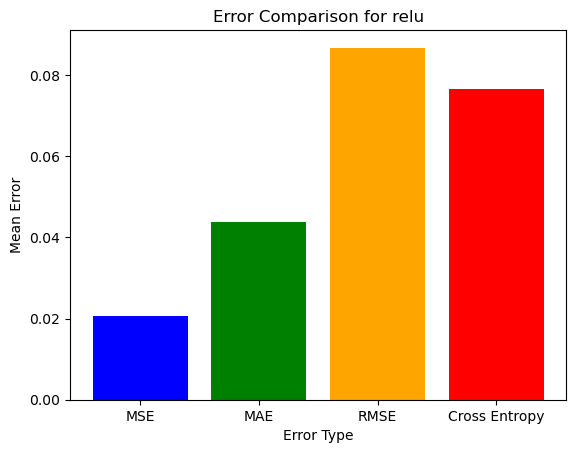

1/10, error=0.088956
2/10, error=0.083943
3/10, error=0.075554
4/10, error=0.065514
5/10, error=0.055917
6/10, error=0.047529
7/10, error=0.040899
8/10, error=0.035668
9/10, error=0.031452
10/10, error=0.028082
---------------sigmoid-----------------
ratio: 0.80
mse: 0.0331
mae: 0.0845
rmse: 0.1517
r2 Score: 0.6323
cross_entropy_loss: 0.1218


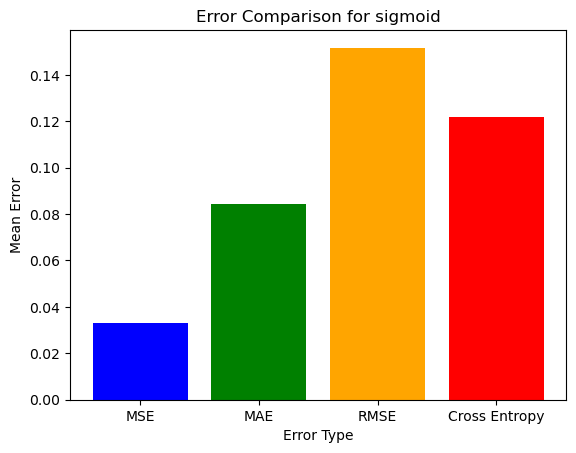

1/10, error=0.064182
2/10, error=0.030455
3/10, error=0.021361
4/10, error=0.017044
5/10, error=0.014309
6/10, error=0.012335
7/10, error=0.010777
8/10, error=0.009516
9/10, error=0.008478
10/10, error=0.007598
---------------tanh-----------------
ratio: 0.85
mse: 0.0218
mae: 0.0468
rmse: 0.0923
r2 Score: 0.7575
cross_entropy_loss: 0.0805


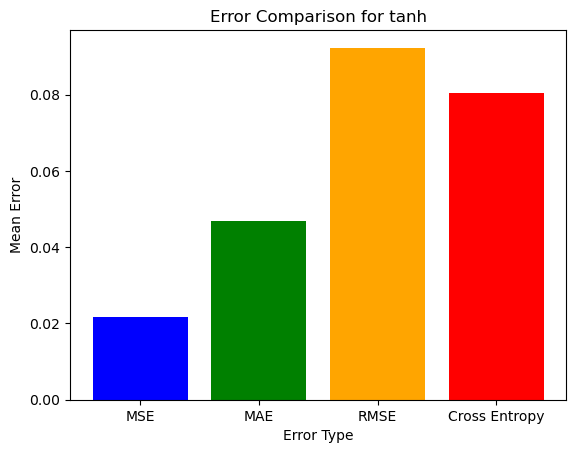



-------------final comparison-------------




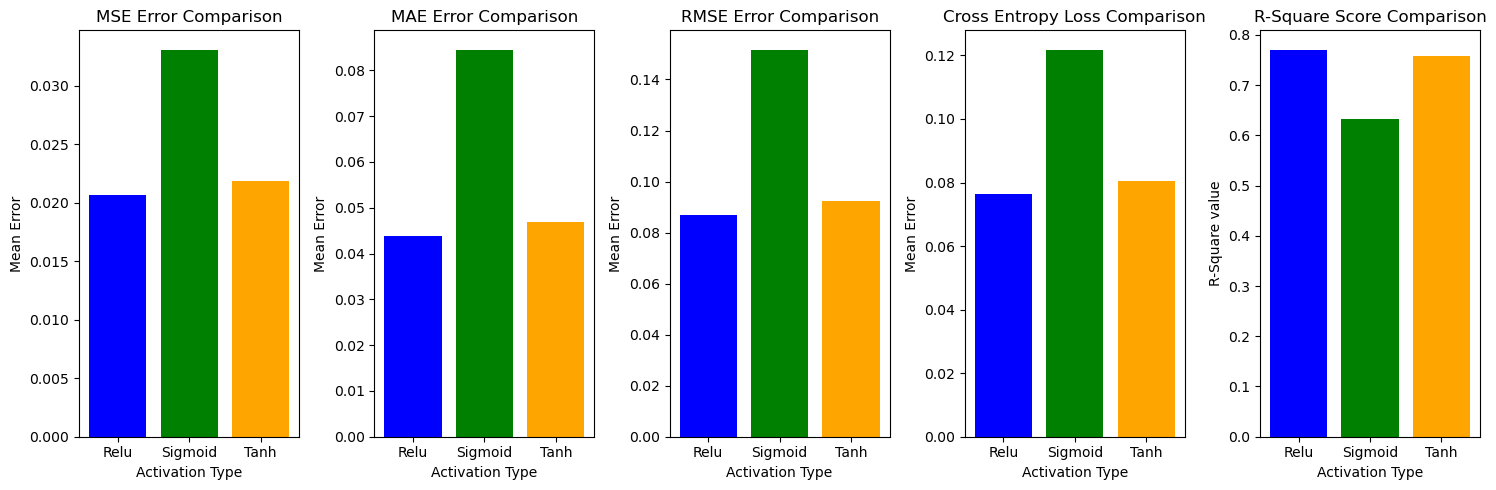

In [19]:
actv=['relu','sigmoid','tanh']

for activation_func in actv:
    if activation_func == 'relu':
        network=train_model(relu, relu_prime)
        relu_mean_r2,relu_mean_cross_entropy_loss,relu_mean_mse,relu_mean_mae,relu_mean_rmse=error_comparison(network,'relu')
    elif activation_func == 'sigmoid':
        network=train_model(sigmoid, sigmoid_prime)
        sigmoid_mean_r2,sigmoid_mean_cross_entropy_loss,sigmoid_mean_mse,sigmoid_mean_mae,sigmoid_mean_rmse=error_comparison(network,'sigmoid')
    elif activation_func == 'tanh':
        network=train_model(tanh, tanh_prime)
        tanh_mean_r2,tanh_mean_cross_entropy_loss,tanh_mean_mse,tanh_mean_mae,tanh_mean_rmse=error_comparison(network,'tanh')
        
        
        
        
print('\n\n-------------final comparison-------------\n\n')
error_labels = ['Relu', 'Sigmoid', 'Tanh']
mse_errors = [relu_mean_mse, sigmoid_mean_mse, tanh_mean_mse]
mae_errors = [relu_mean_mae, sigmoid_mean_mae, tanh_mean_mae]
rmse_errors = [relu_mean_rmse, sigmoid_mean_rmse, tanh_mean_rmse]
cross_entropy_error=[relu_mean_cross_entropy_loss,sigmoid_mean_cross_entropy_loss,tanh_mean_cross_entropy_loss]
r2_value=[relu_mean_r2,sigmoid_mean_r2,tanh_mean_r2]
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))

# Plot Mean Squared Error (MSE) comparison
axes[0].bar(error_labels, mse_errors, color=['blue', 'green', 'orange'])
axes[0].set_xlabel('Activation Type')
axes[0].set_ylabel('Mean Error')
axes[0].set_title('MSE Error Comparison')

# Plot Mean Absolute Error (MAE) comparison
axes[1].bar(error_labels, mae_errors, color=['blue', 'green', 'orange'])
axes[1].set_xlabel('Activation Type')
axes[1].set_ylabel('Mean Error')
axes[1].set_title('MAE Error Comparison')

# Plot Root Mean Squared Error (RMSE) comparison
axes[2].bar(error_labels, rmse_errors, color=['blue', 'green', 'orange'])
axes[2].set_xlabel('Activation Type')
axes[2].set_ylabel('Mean Error')
axes[2].set_title('RMSE Error Comparison')

axes[3].bar(error_labels, cross_entropy_error, color=['blue', 'green', 'orange'])
axes[3].set_xlabel('Activation Type')
axes[3].set_ylabel('Mean Error')
axes[3].set_title('Cross Entropy Loss Comparison')

axes[4].bar(error_labels, r2_value, color=['blue', 'green', 'orange'])
axes[4].set_xlabel('Activation Type')
axes[4].set_ylabel('R-Square value')
axes[4].set_title('R-Square Score Comparison')
# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

## Sample Output

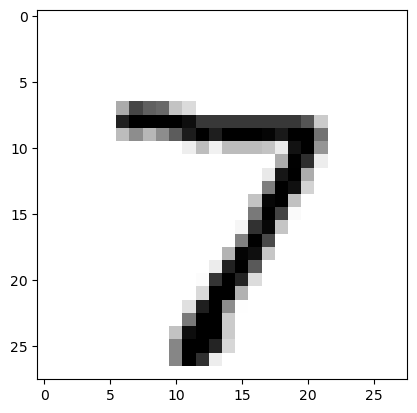

pred: 7, prob: 1.00, true: 7


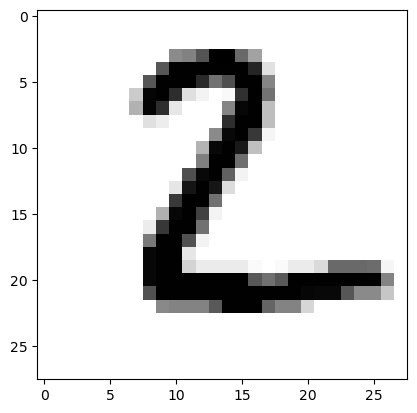

pred: 2, prob: 0.54, true: 2


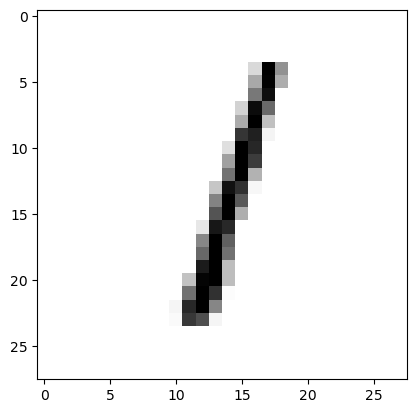

pred: 1, prob: 0.96, true: 1


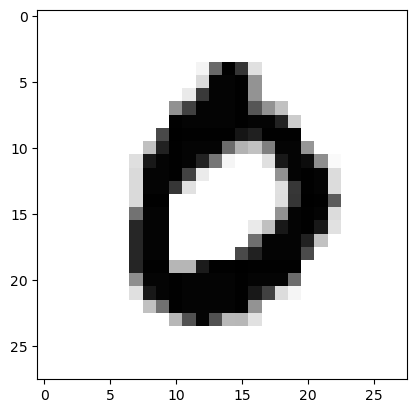

pred: 0, prob: 0.98, true: 0


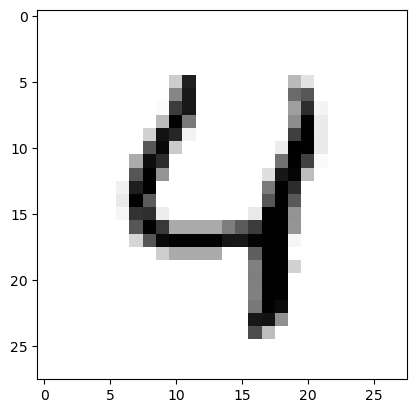

pred: 4, prob: 0.87, true: 4


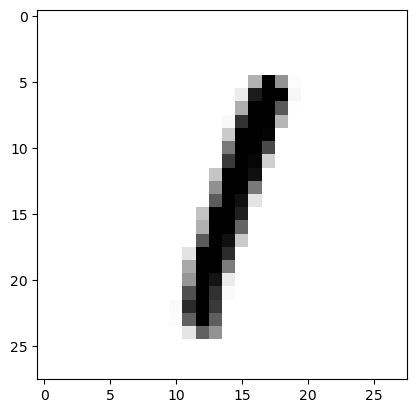

pred: 1, prob: 0.91, true: 1


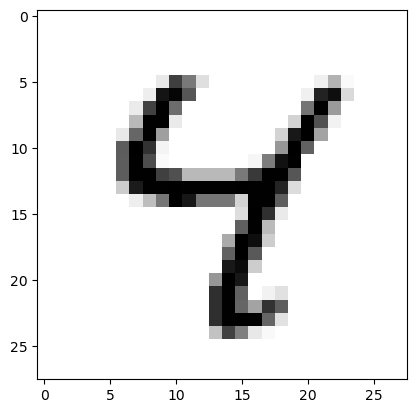

pred: 4, prob: 0.90, true: 4


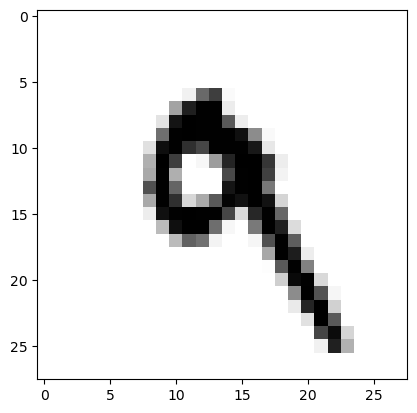

pred: 9, prob: 0.89, true: 9


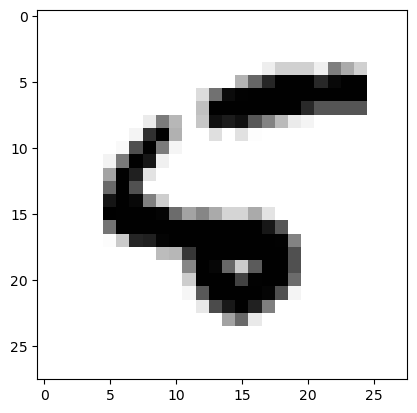

pred: 2, prob: 0.52, true: 5


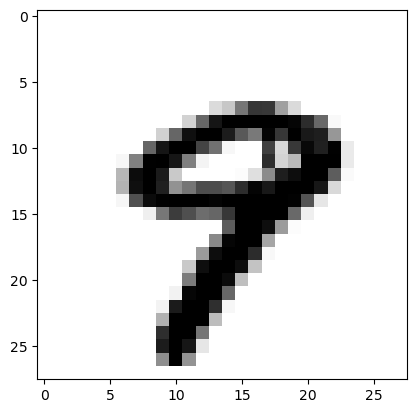

pred: 9, prob: 0.51, true: 9


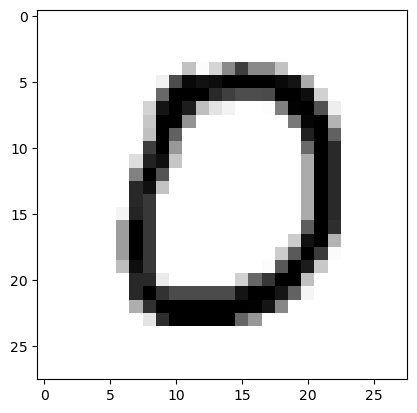

pred: 0, prob: 0.87, true: 0


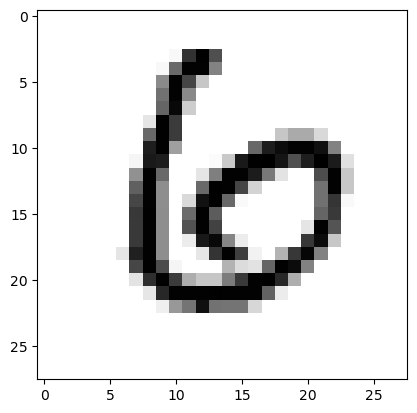

pred: 2, prob: 0.44, true: 6


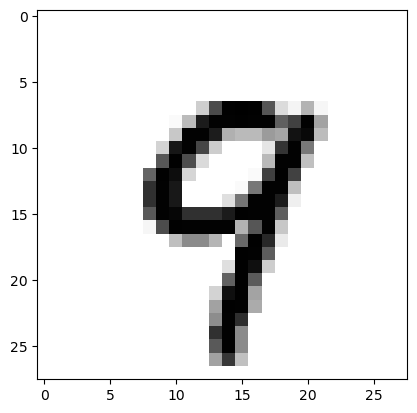

pred: 9, prob: 0.89, true: 9


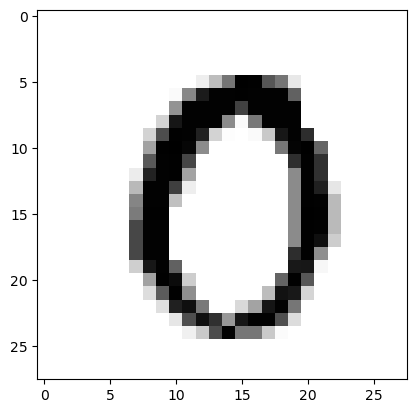

pred: 0, prob: 0.98, true: 0


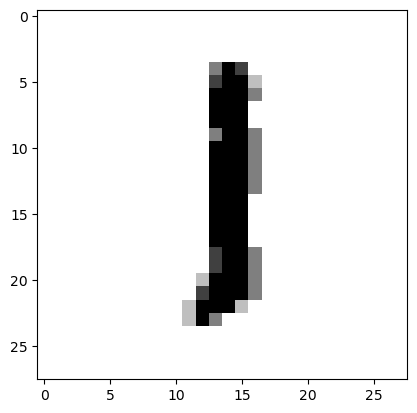

pred: 1, prob: 0.97, true: 1


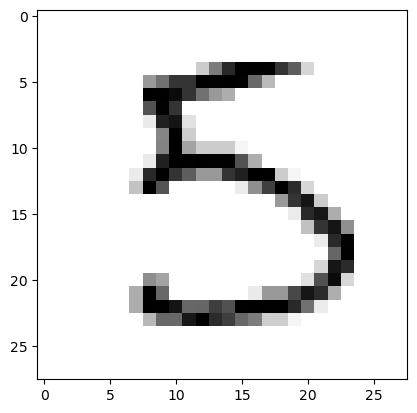

pred: 5, prob: 0.49, true: 5


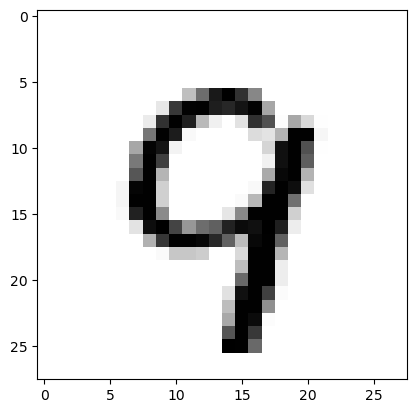

pred: 7, prob: 0.56, true: 9


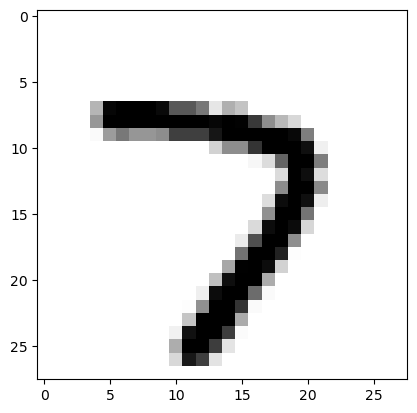

pred: 7, prob: 0.98, true: 7


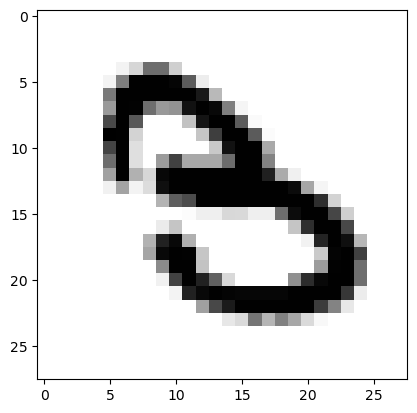

pred: 3, prob: 0.70, true: 3


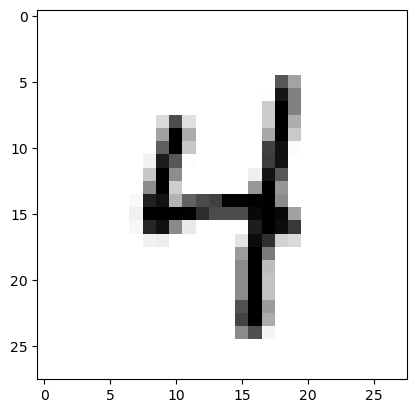

pred: 4, prob: 0.90, true: 4


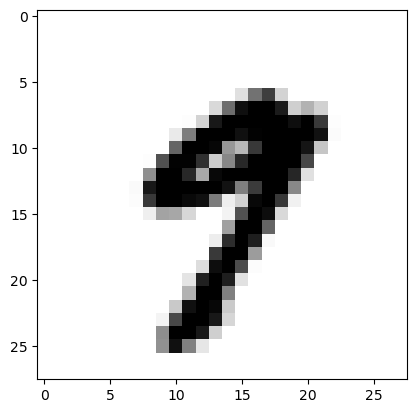

pred: 9, prob: 0.67, true: 9


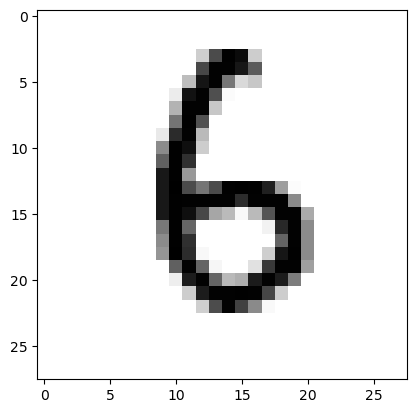

pred: 6, prob: 0.95, true: 6


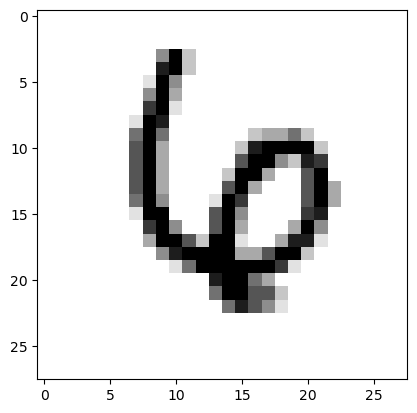

pred: 6, prob: 0.39, true: 6


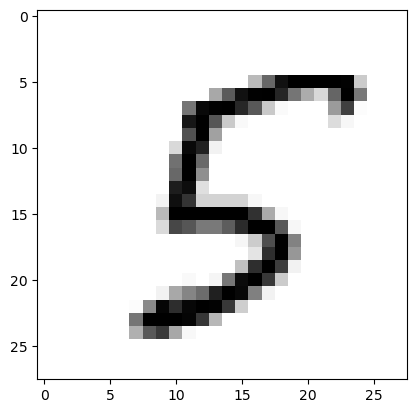

pred: 5, prob: 0.97, true: 5


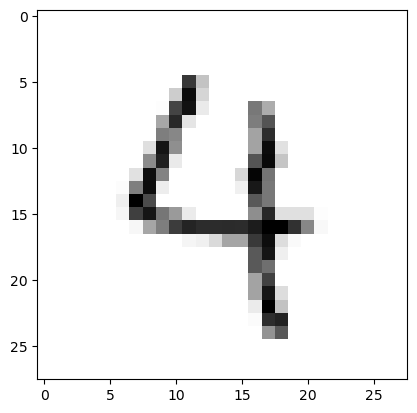

pred: 4, prob: 0.81, true: 4


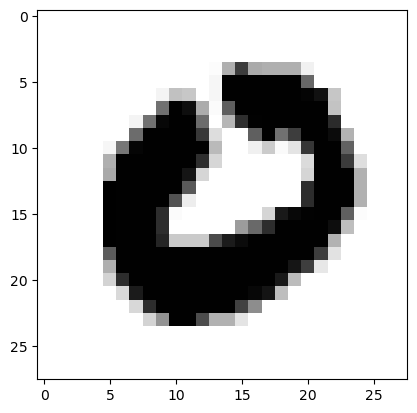

pred: 0, prob: 0.99, true: 0


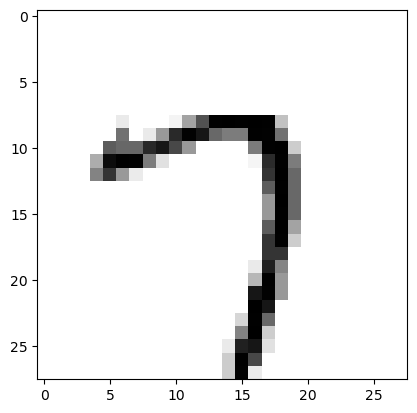

pred: 7, prob: 0.98, true: 7


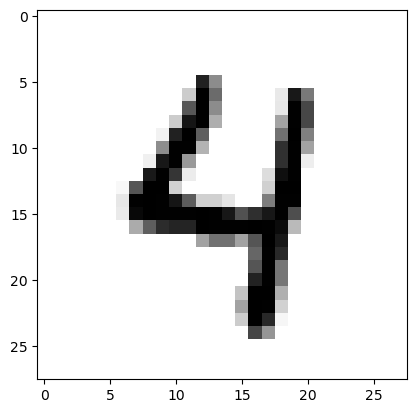

pred: 4, prob: 0.90, true: 4


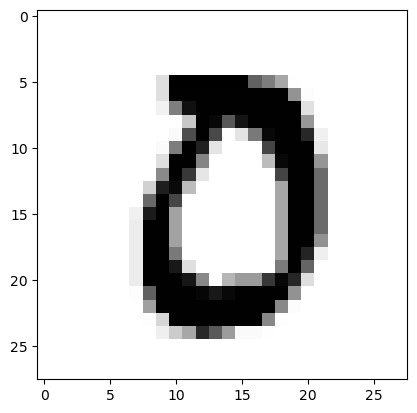

pred: 0, prob: 0.99, true: 0


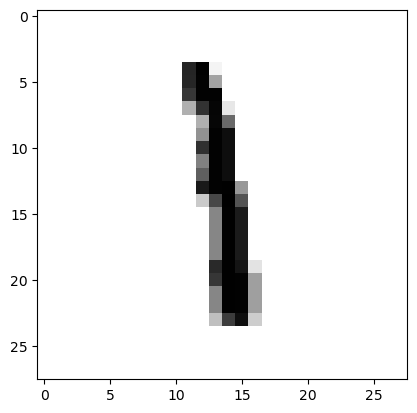

pred: 1, prob: 0.92, true: 1


In [20]:
samples = 30
for test, true in zip(x_test[:samples], y_test[:samples]):
    image = np.reshape(test, (28, 28))
    plt.imshow(image, cmap='binary')
    plt.show()
    pred = predict(network, test)[0]
    idx = np.argmax(pred)
    idx_true = np.argmax(true)
    print('pred: %s, prob: %.2f, true: %d' % (idx, pred[idx], idx_true))